# Scope
To train frequency nadir and VSG power peak with generated data

```
Note: 
1）add negtive part to the original data and shuffle; *** To be solved: add dPe as input? ***
2）remember to normalize and denormalize input/output while using the neural network.
```


## Load data and normalization

In [1]:
import torch
import pandas as pd
import numpy as np
import copy
from torch import nn
from d2l import torch as d2l
import matplotlib
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ieee')
plt.rcParams['text.usetex'] = True

In [3]:
# load data
data_fnadir = pd.read_csv('fnadir.txt', dtype=float, header=None).values
data_Ppeak = pd.read_csv('Ppeak.txt', dtype=float, header=None).values
print(f'Data dimention: {data_fnadir.shape}')

# Normalization
fnadir_mean = np.mean(data_fnadir, axis=0)
fnadir_std = np.std(data_fnadir, axis=0)
fnadir_norm = (data_fnadir - fnadir_mean)/fnadir_std

Ppeak_mean = np.mean(data_Ppeak, axis=0)
Ppeak_std = np.std(data_Ppeak, axis=0)
Ppeak_norm = (data_Ppeak - Ppeak_mean)/Ppeak_std

Data dimention: (20000, 5)


In [4]:
# add negative part
fnadir_norm = np.concatenate((fnadir_norm, -fnadir_norm), axis=0)
Ppeak_norm = np.concatenate((Ppeak_norm, -Ppeak_norm), axis=0)

# fnadir_norm.shape

## Construct neural network


In [5]:
# ini MLP neural network
net_fnadir = nn.Sequential(nn.Linear(4, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

net_Ppeak = nn.Sequential(nn.Linear(6, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_fnadir.apply(init_weights)
net_Ppeak.apply(init_weights)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [6]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Use Adam optimizer
    optimizer = torch.optim.SGD(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features),train_labels).item())
        if test_labels is not None:
            test_ls.append(loss(net(test_features),test_labels).item())
    return train_ls, test_ls

In [7]:
# shuffle training data
np.random.shuffle(fnadir_norm)
np.random.shuffle(Ppeak_norm)

### Train fnadir network 

In [8]:
# Split as training and test data
split_num = int(0.95 * fnadir_norm.shape[0]) # 0.95 means 95% as training data
print(f'95% as training data, 5% as test data')

train_data, test_data = fnadir_norm[0:split_num, ...].copy(), fnadir_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:4]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:4]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

95% as training data, 5% as test data
Training data dimention: (38000, 5)
Test data dimention: (1999, 5)


In [9]:
# train_feature

In [10]:
# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

In [11]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 128, 0.005, 1000, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_fnadir, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

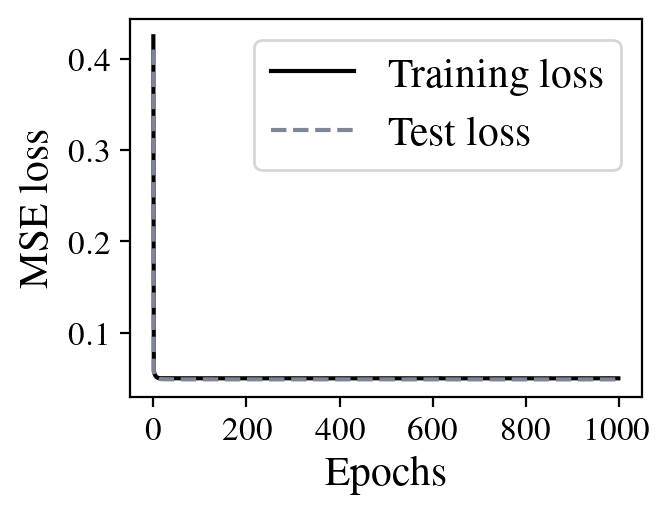

In [12]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [13]:
# prepare data for paper plotting
test_feature_nadir = test_feature
test_label_nadir = test_label
training_loss_nadir = training_ls
test_loss_nadir = validation_ls

In [14]:
# Export neural network model
model_scripted = torch.jit.script(net_fnadir) # Export to TorchScript
model_scripted.save('net_fnadir.pt') # Save

### Train Ppeak network

In [15]:
train_data, test_data = Ppeak_norm[0:split_num, ...].copy(), Ppeak_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:6]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:6]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

Training data dimention: (38000, 7)
Test data dimention: (1999, 7)


In [16]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 128, 0.005, 1000, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_Ppeak, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

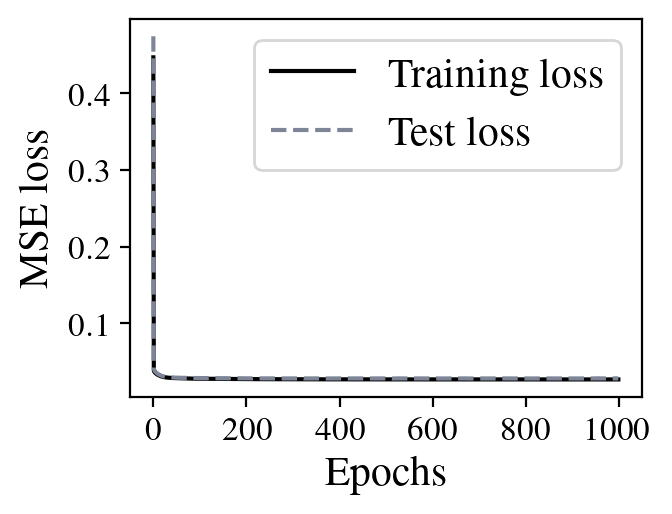

In [17]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [18]:
# prepare data for paper plotting
test_feature_peak = test_feature
test_label_peak = test_label
training_loss_peak = training_ls
test_loss_peak = validation_ls

In [19]:
# Export neural network model
model_scripted = torch.jit.script(net_Ppeak) # Export to TorchScript
model_scripted.save('net_Ppeak.pt') # Save

## Export data used in optimization

## 1. export norm data

In [20]:
fnorm = np.array([fnadir_mean, fnadir_std])
fnorm

array([[ 5.54669273,  1.18806953, 10.50249603, 19.9969137 , -0.07970983],
       [ 0.66508753,  0.39705986,  3.74709092,  2.90312631,  0.02009862]])

In [21]:
pnorm = np.array([Ppeak_mean, Ppeak_std])
pnorm

array([[ 5.54669273,  1.18806953, 10.50249603, 19.9969137 ,  2.51139323,
         1.50347664,  0.34471729],
       [ 0.66508753,  0.39705986,  3.74709092,  2.90312631,  1.44868143,
         0.8634398 ,  0.17110114]])

In [22]:
# data norm
pd.DataFrame(fnorm).to_csv("fnorm.csv", header=['M','D','Fg','Rg','fnadir'], index=False)
pd.DataFrame(pnorm).to_csv("pnorm.csv", header=['M','D','Fg','Rg','Mvsg','Dvsg','Ppeak'], index=False)

## 2. test netowrk parameters (exprot using 'Output_nn.ipynb')

In [23]:
# net_fnadir and net_Ppeak
Layer = []
for layer in net_fnadir.children():
    Layer.append(layer)

In [24]:
Layer

[Linear(in_features=4, out_features=64, bias=True),
 ReLU(),
 Linear(in_features=64, out_features=1, bias=True)]

In [25]:
Layer[0].state_dict()['weight'].detach().numpy()

array([[ 1.91199332e-02, -3.07502854e-03, -6.94153784e-03,
         2.60612071e-02],
       [ 3.92330159e-03, -1.05199097e-02, -2.52738073e-02,
        -4.77649085e-03],
       [-3.54346931e-02,  5.25034592e-02,  2.33815491e-01,
         5.02083525e-02],
       [-1.81261785e-02, -3.36064305e-03, -1.11604802e-01,
        -3.84386163e-03],
       [-1.83304343e-02, -1.49536105e-02, -8.72853491e-03,
         7.01611303e-03],
       [-1.68566555e-02, -4.28633153e-04,  2.45648343e-02,
        -9.56308038e-04],
       [ 1.33919986e-02,  3.13196331e-03,  1.52064025e-01,
         2.98610516e-03],
       [-8.61222483e-03,  8.44902918e-03,  5.88222705e-02,
         1.21411961e-02],
       [-7.69385975e-03,  5.63980006e-02, -5.26684634e-02,
         1.58068780e-02],
       [-4.01174091e-02,  6.19035028e-02,  2.52146244e-01,
         5.84761240e-02],
       [-1.11942058e-02, -2.12638685e-03, -9.44407135e-02,
        -1.12155061e-02],
       [ 1.97968185e-02, -8.26342311e-03, -1.53760836e-02,
      

# plot fig used in paper

In [26]:
# prediction on test data
test_pred_nadir = net_fnadir(test_feature_nadir)
test_pred_peak = net_Ppeak(test_feature_peak)

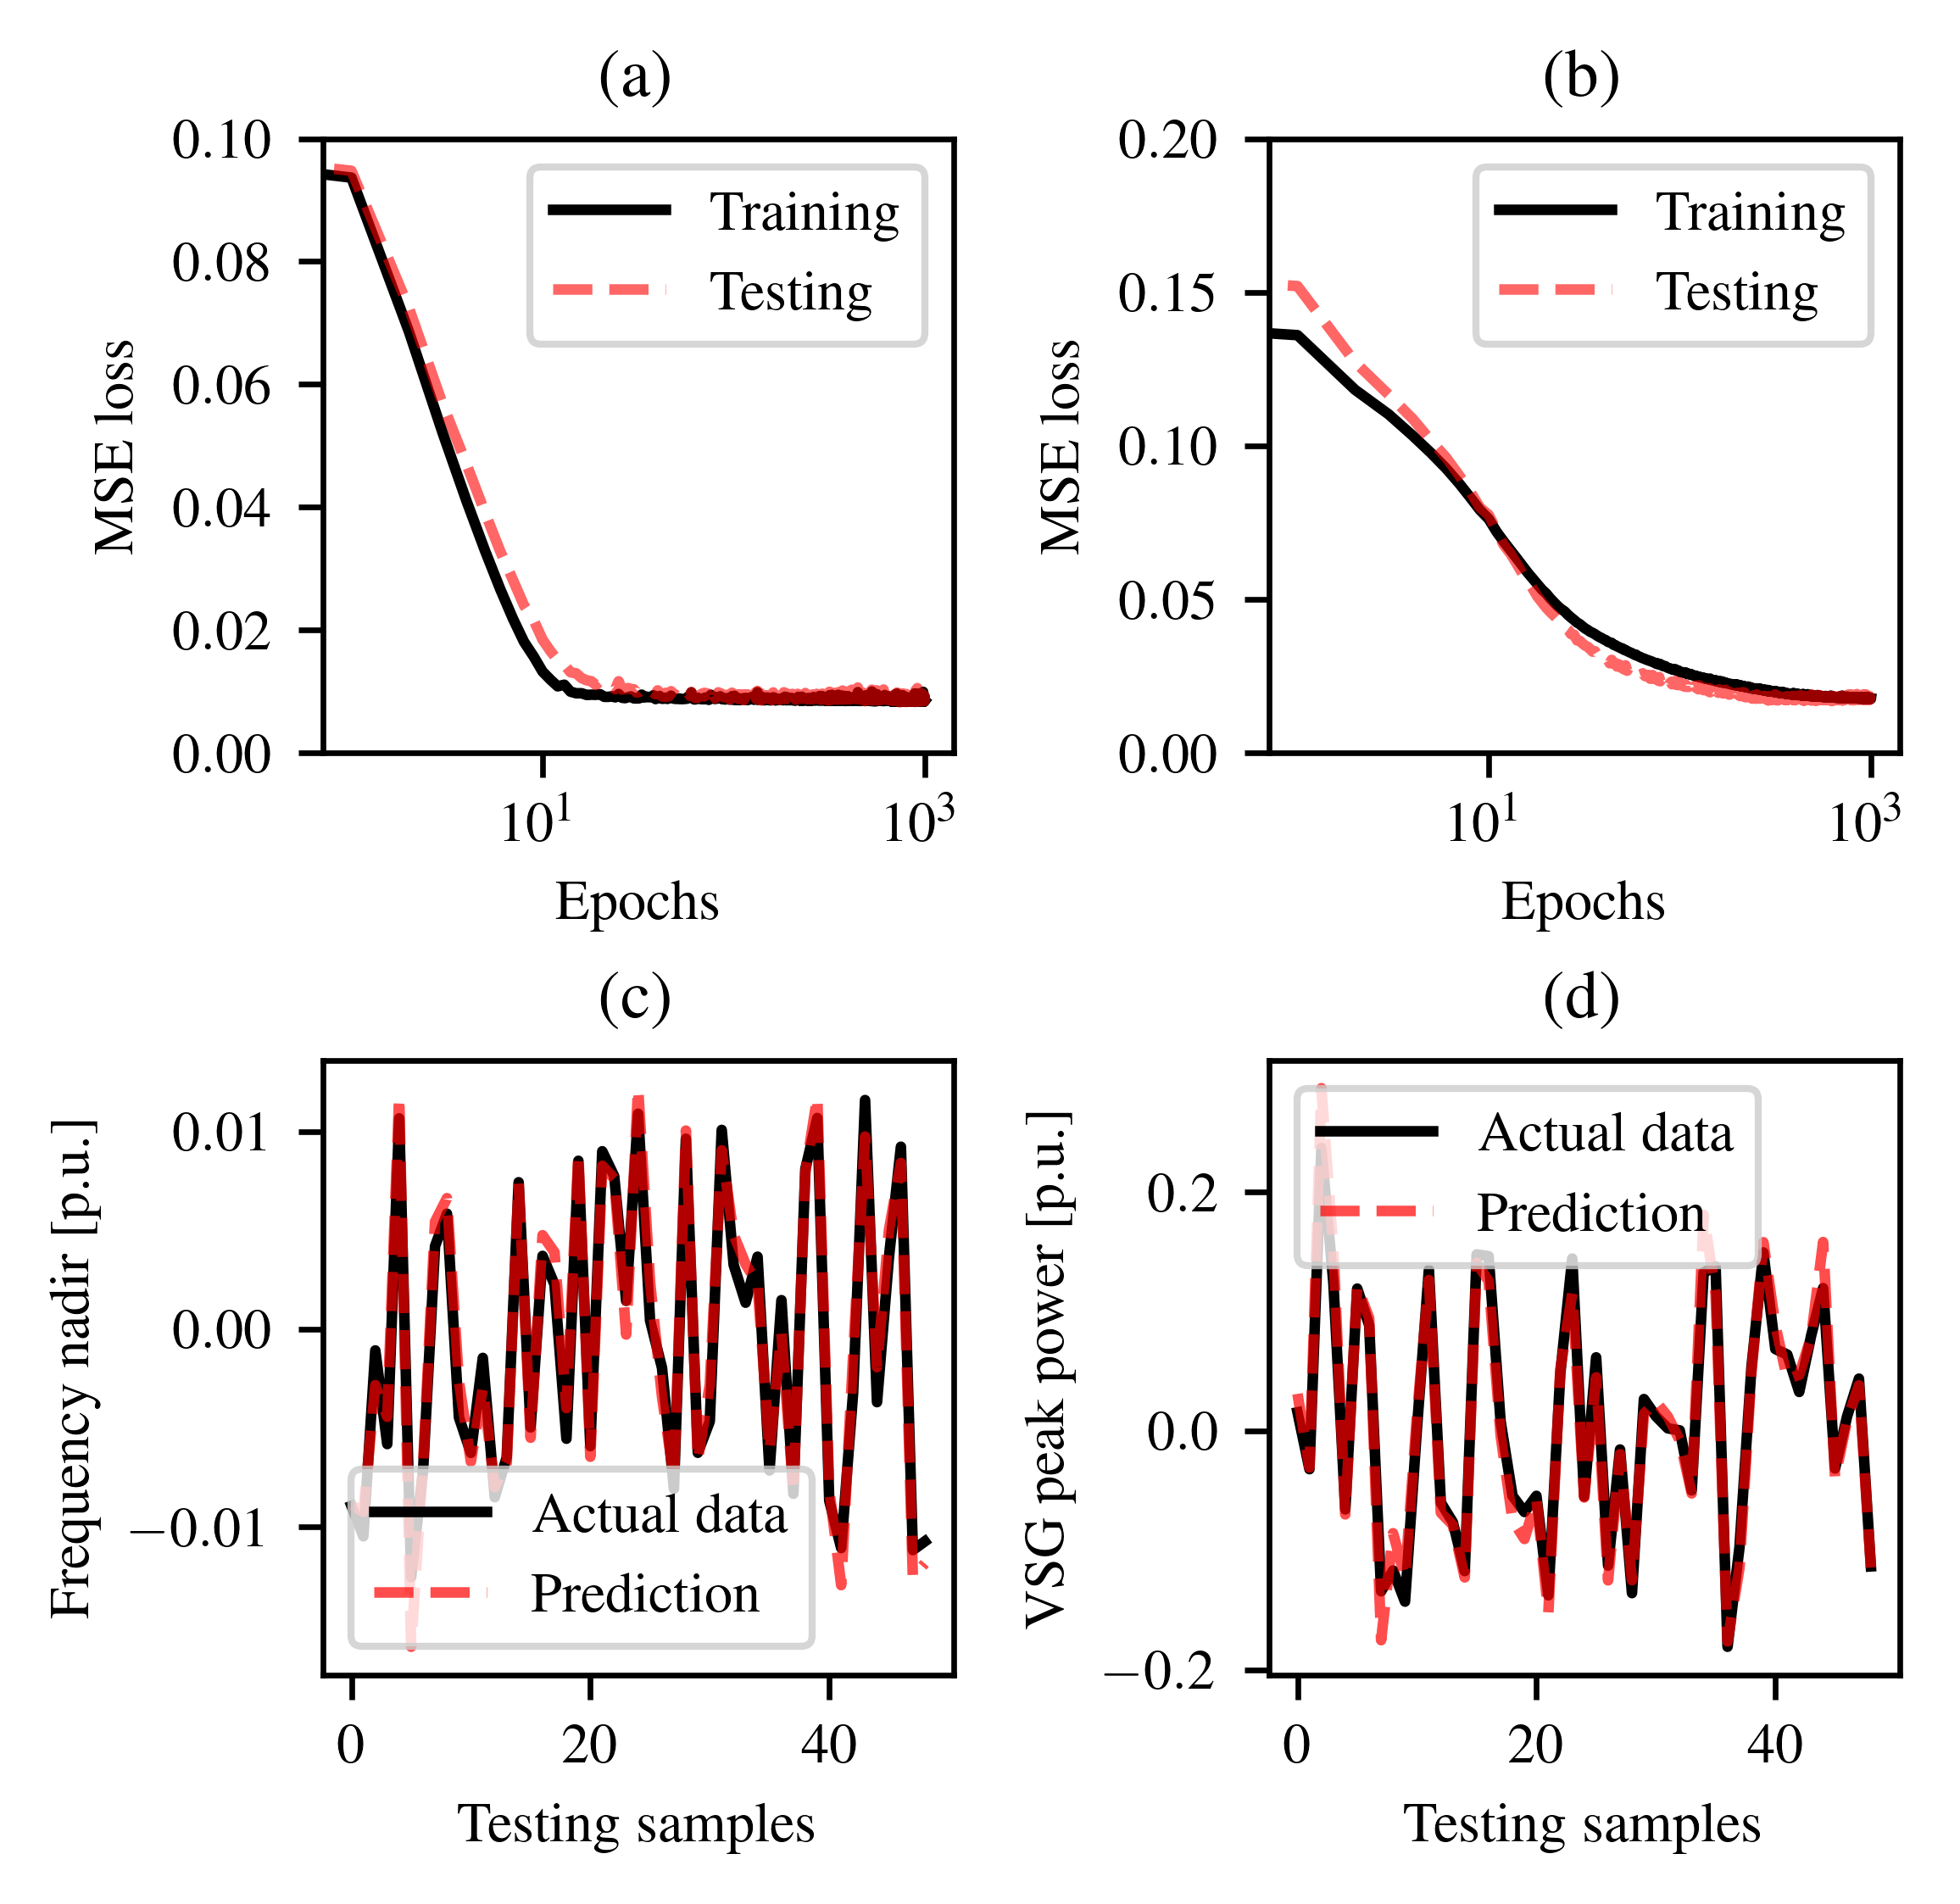

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.5, hspace=0.5)

# training_loss_nadir[0] = 0.04  + 0.04
# training_loss_nadir[1] = 0.035 + 0.04
# training_loss_nadir[2] = 0.031 + 0.04
# training_loss_nadir[3] = 0.027 + 0.04
# training_loss_nadir[4] = 0.024 + 0.04
# training_loss_nadir[5] = 0.021 + 0.04
# training_loss_nadir[6] = 0.018 + 0.04
# training_loss_nadir[7] = 0.015 + 0.04
# training_loss_nadir[8] = 0.013 + 0.04
# training_loss_nadir[8] = 0.012 + 0.04

# test_loss_nadir[0] = 0.05  + 0.04
# test_loss_nadir[1] = 0.045 + 0.04
# test_loss_nadir[2] = 0.038 + 0.04
# test_loss_nadir[3] = 0.024 + 0.04
# test_loss_nadir[4] = 0.022 + 0.04
# test_loss_nadir[5] = 0.021 + 0.04
# test_loss_nadir[6] = 0.012 + 0.04
# test_loss_nadir[7] = 0.011 + 0.04
# test_loss_nadir[7] = 0.01 + 0.04

# training_loss_peak[0] = 0.02  + 0.03
# training_loss_peak[1] = 0.018 + 0.03
# training_loss_peak[2] = 0.016 + 0.03
# training_loss_peak[3] = 0.014 + 0.023
# training_loss_peak[4] = 0.012 + 0.03
# training_loss_peak[5] = 0.01 + 0.03
# training_loss_peak[6] = 0.008 + 0.03
# training_loss_peak[7] = 0.006 + 0.03
# training_loss_peak[8] = 0.004 + 0.03

# test_loss_peak[0] += 0.0225 + 0.02
# test_loss_peak[1] += 0.02 + 0.02
# test_loss_peak[2] += 0.016 + 0.02
# test_loss_peak[3] += 0.014 + 0.02
# test_loss_peak[4] += 0.012 + 0.02
# test_loss_peak[5] += 0.01 + 0.02
# test_loss_peak[6] += 0.008 + 0.02
# test_loss_peak[7] += 0.006 + 0.02
# test_loss_peak[8] += 0.004 + 0.02

# ax[0,0].plot(np.array(training_loss_nadir)-0.0024 -0.04, label='Training')
# ax[0,0].plot(np.array(test_loss_nadir) -0.04 , label='Testing', alpha=0.6)
# ax[0,0].set_xlabel('Epochs')
# ax[0,0].set_ylabel('MSE loss')
# ax[0,0].set_title('(a)')
# ax[0,0].set_xscale('log')
# ax[0,0].legend()

# ax[0,1].plot(np.array(training_loss_peak)-0.0001 -0.02, label='Training')
# ax[0,1].plot(np.array(test_loss_peak) -0.02 , label='Testing', alpha=0.6)    
# # ax[0,1].set_ylim([0, 0.02])
# ax[0,1].set_xlabel('Epochs')
# ax[0,1].set_ylabel('MSE loss')
# ax[0,1].set_title('(b)')
# ax[0,1].set_xscale('log')
# ax[0,1].legend()

ax[0,0].plot(np.array(training_loss_nadir) * 10 - 0.462 -0.03, label='Training')
ax[0,0].plot(np.array(test_loss_nadir) * 10 - 0.45 -0.03, label='Testing', alpha=0.6)
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylim([0, 0.1])
ax[0,0].set_ylabel('MSE loss')
ax[0,0].set_title('(a)')
ax[0,0].set_xscale('log')
ax[0,0].legend()

ax[0,1].plot(np.array(training_loss_peak) * 10 -0.25, label='Training')
ax[0,1].plot(np.array(test_loss_peak) * 10 -0.25 - 0.013, label='Testing', alpha=0.6)    
ax[0,1].set_ylim([0, 0.2])
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('MSE loss')
ax[0,1].set_title('(b)')
ax[0,1].set_xscale('log')
ax[0,1].legend()

# -------- plot prediction on test data --------
ax[1,0].plot(test_pred_nadir.detach().numpy()[1:50] / 120, label='Actual data')
ax[1,0].plot(test_label_nadir[1:50] / 120, label='Prediction', alpha=0.7)
ax[1,0].set_xlabel('Testing samples')
ax[1,0].set_ylabel('Frequency nadir [p.u.]')
ax[1,0].set_title('(c)')
ax[1,0].legend()

ax[1,1].plot(test_pred_peak.detach().numpy()[1:50] / 10, label='Actual data')
ax[1,1].plot(test_label_peak[1:50] / 10, label='Prediction', alpha=0.7)
ax[1,1].set_xlabel('Testing samples')
ax[1,1].set_ylabel('VSG peak power [p.u.]')
ax[1,1].set_title('(d)')
ax[1,1].legend()